# Intersection Crash Analysis Using Only Intersection Characteristics

Linear regression analysis of factors affecting red light crashes

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
import warnings
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [125]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db


In [126]:
print(sql_fetch_tables(c, conn))
#table_info(c, conn)  # use if you need to see columns

[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('signal_crashes',), ('all_hours',), ('int_startend',), ('intersection_chars',), ('hourly_congestion',)]


## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [127]:
#create my db
crash_df = pd.read_sql_query('''
WITH v AS(SELECT dv.intersection,
                SUM(dv.violations) as violations,
                (CASE
                      WHEN JulianDay(se.start) <= JulianDay('2017-09-01 00:00:00')
                      AND JulianDay(se.end) > JulianDay('2020-12-31 00:00:00')
                          THEN CAST((JulianDay('2020-12-31 00:00:00')) - JulianDay('2017-09-01 00:00:00') as Integer)
                      
                      WHEN JulianDay(se.start) > JulianDay('2017-09-01 00:00:00')
                      AND JulianDay(se.end) > JulianDay('2020-12-31 00:00:00')
                          THEN CAST (JulianDay('2020-12-31 00:00:00') - JulianDay(se.start) as Integer)
                      
                      WHEN JulianDay(se.start) > JulianDay('2017-09-01 00:00:00')
                      AND JulianDay(se.end) <= JulianDay('2020-12-31 00:00:00')
                          THEN CAST ((se.end) - JulianDay(se.start) as Integer)
                    
                      ELSE CAST (JulianDay(se.end) - JulianDay('2017-09-01 00:00:00') as Integer)
                END) AS days_active,
                COUNT(DISTINCT dv.camera_id) as n_cams,
                start,
                end

        FROM daily_violations as dv
        LEFT JOIN int_startend as se
            ON se.intersection = dv.intersection

        GROUP BY dv.intersection
        ), 

    ic AS(SELECT *
         FROM intersection_chars
        ),

    cr AS(SELECT *   
         FROM signal_crashes
        )

SELECT 
    (CAST(365 * SUM(cr.injuries_total) AS FLOAT) / v.days_active) as injuries_per_year,
    (CAST(365 * COUNT(cr.crash_record_id) AS FLOAT)/ v.days_active) as crash_per_year,
    ( (CAST(365 * COUNT(cr.crash_record_id) AS FLOAT)/ v.days_active) +
      (CAST(365 * SUM(cr.injuries_total) AS FLOAT) / v.days_active) +
      (CAST(365 * SUM(cr.injuries_incapacitating) AS FLOAT) / v.days_active)) AS danger_metric,


    (CAST((ic.daily_traffic/ic.total_lanes) AS FLOAT)) as traffic_per_lane,
    (CAST(ic.daily_traffic AS int)) as traffic,
    ic.protected_turn/ic.way as protected_ratio,

    (ic.exit + ic.triangle + ic.angled + ic.one_way + ic.underpass) as complexity,

    ic.*,
    
    v.n_cams,
    (CAST(365 * v.violations AS FLOAT) / v.days_active) as violations_per_year,
    COUNT(crash_record_id) as n_crash,
    SUM(injuries_total) as injuries_total,
    SUM(injuries_fatal) as injuries_fatal,
    SUM(injuries_non_incapacitating) as injuries_non_incapacitating,

    (CAST(ic.total_lanes AS FLOAT)/ic.way) AS lanes_per_direction    

FROM v  
LEFT JOIN ic
ON v.intersection = ic.intersection
LEFT JOIN cr
ON cr.intersection = ic.intersection
WHERE cr.crash_date >= \'2017-09-01\' AND cr.crash_date <= \'2020-12-31\'
GROUP BY ic.intersection
ORDER BY ic.intersection
                                    ''', conn)

crash_df.head()

,injuries_per_year,crash_per_year,danger_metric,traffic_per_lane,traffic,protected_ratio,complexity,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,intersection,daily_traffic,speed,n_cams,violations_per_year,n_crash,injuries_total,injuries_fatal,injuries_non_incapacitating,lanes_per_direction
0,10.197206,13.496302,24.593262,7183.0,43100,0,1,2,6,2,0,0,4,0,0,1,0,0,2,41.692362,-87.642423,1,111TH AND HALSTED,43100,35,2,6683.368940,45,34,0,18,1.5
1,132.727273,258.818182,411.454545,7083.0,42500,1,0,4,6,2,0,0,4,0,0,0,0,0,4,41.685089,-87.642094,1,115TH AND HALSTED,42500,35,2,68155.454545,39,20,0,8,1.5
2,6.598192,11.696795,18.594906,6966.0,41800,1,0,4,6,2,0,0,4,0,0,0,0,0,4,41.677774,-87.641930,1,119TH AND HALSTED,41800,35,2,6200.201315,39,22,0,11,1.5
3,5.698439,13.196385,19.194741,3650.0,36500,0,0,2,10,2,0,1,4,0,2,0,0,0,0,41.838441,-87.617338,1,31ST ST AND MARTIN LUTHER KING DRIVE,36500,35,2,7910.632703,44,19,0,11,2.5
4,5.698439,21.894002,27.892358,5300.0,42400,0,0,2,8,2,0,1,4,0,0,0,0,0,2,41.830281,-87.684775,1,35TH AND WESTERN,42400,35,2,3315.891537,73,19,0,14,2.0


In [128]:


sql_fetch_tables(c, conn)

[('cam_locations',),
 ('cam_startend',),
 ('daily_violations',),
 ('all_crashes',),
 ('hourly_weather',),
 ('region_data',),
 ('intersection_cams',),
 ('signal_crashes',),
 ('all_hours',),
 ('int_startend',),
 ('intersection_chars',),
 ('hourly_congestion',)]

In [129]:
crash_df.drop_duplicates(inplace=True)
crash_df = crash_df.loc[:,~crash_df.columns.duplicated()]  # had a single dupe column preventing modeling

In [130]:
# need to drop all of the rows I don't have data for
try:
    crash_df.dropna(subset=['crash_record_id'], inplace=True)
except Exception as e:
    print(e)

['crash_record_id']


In [131]:
# now drop out the rows that do not have daily violations. Should cure all our nans
# Some of these cams were only running before our query.
crash_df.dropna(subset=['violations_per_year'], inplace=True)
crash_df.dropna(subset=['intersection'], inplace=True)
crash_df = crash_df.loc[:,~crash_df.columns.duplicated()]  # had a dupe column preventing modeling


Now we have a pretty solid dataframe to do analysis on the red light intersections.

We would like to know what factors affect the target (danger)

In [133]:
df_final = crash_df.copy()  # so I don't change my dataset

In [134]:
df_final.columns

Index(['injuries_per_year', 'crash_per_year', 'danger_metric',
       'traffic_per_lane', 'traffic', 'protected_ratio', 'complexity',
       'protected_turn', 'total_lanes', 'medians', 'exit', 'split', 'way',
       'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes',
       'lat', 'long', 'rlc', 'intersection', 'daily_traffic', 'speed',
       'n_cams', 'violations_per_year', 'n_crash', 'injuries_total',
       'injuries_fatal', 'injuries_non_incapacitating', 'lanes_per_direction'],
      dtype='object')

## Single variable regression

In [135]:
# Lets look at some regressions for all of my chosen columns

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# I don't need to see regression analysis for all of my variables
target = 'n_crash'


continuous = [target, 'traffic', 'protected_turn', 'total_lanes', 
              'medians', 'way','turn_lanes', 'speed', 
              'violations_per_year', 'n_cams', 'one_way', 'complexity']

categoricals = ['exit', 'split', 'underpass', 'angled', 'triangle', 'no_left', ]

df_cont = df_final[continuous]



results = []

for idx, column in enumerate(df_cont.columns):
    print()
    print((column.upper() + " **** ") * 5)
    print ("Red Light Camera Crash - Injuries")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
#     fig, axes = plt.subplots(figsize=(15,12))
#     fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
#     fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
#     fig.tight_layout()
#     plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')


N_CRASH **** N_CRASH **** N_CRASH **** N_CRASH **** N_CRASH **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.148e+32
Date:                Sat, 20 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:16:42   Log-Likelihood:                 4789.3
No. Observations:                 156   AIC:                            -9575.
Df Residuals:                     154   BIC:                            -9569.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     19.83
Date:                Sat, 20 Feb 2021   Prob (F-statistic):           1.62e-05
Time:                        00:16:42   Log-Likelihood:                -719.24
No. Observations:                 156   AIC:                             1442.
Df Residuals:                     154   BIC:                             1449.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -48.1230     20.035     -2.402      0.0

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
2,protected_turn,0.000172,4.113628e+01,-0.210668,8.710825e-01,2205.467149
6,turn_lanes,0.001909,4.358626e+01,-0.884158,5.881460e-01,2297.436783
8,violations_per_year,0.004419,3.965089e+01,0.000190,4.096605e-01,2414.997360
5,way,0.027446,2.101823e+00,9.401743,3.874620e-02,1266.616736
10,one_way,0.054413,3.847614e+01,10.710062,3.383240e-03,1328.207570
4,medians,0.066306,3.699510e+01,8.563644,1.173661e-03,3330.621638
11,complexity,0.099104,3.559455e+01,6.771365,6.265755e-05,879.494789
1,traffic,0.112757,9.852120e+00,0.000601,1.823846e-05,864.146481
9,n_cams,0.113835,-4.279778e+01,41.337950,1.653804e-05,767.523525
7,speed,0.114091,-4.812304e+01,2.486929,1.615718e-05,1361.065452


In [136]:
df_cont.corr()  # create a correlation matrix

,n_crash,traffic,protected_turn,total_lanes,medians,way,turn_lanes,speed,violations_per_year,n_cams,one_way,complexity
n_crash,1.000000,0.335794,-0.013098,0.580995,0.257500,0.165669,-0.043687,0.337774,0.066474,0.337394,0.233265,0.314807
traffic,0.335794,1.000000,0.321246,0.465157,0.049176,0.289776,0.290851,0.292655,-0.156551,0.126136,0.007119,0.025892
protected_turn,-0.013098,0.321246,1.000000,0.122464,-0.140197,-0.080400,0.393123,0.077431,-0.089766,-0.200369,-0.293077,-0.322843
total_lanes,0.580995,0.465157,0.122464,1.000000,0.371183,0.224935,-0.063664,0.297084,0.039299,0.034879,0.351938,0.334609
medians,0.257500,0.049176,-0.140197,0.371183,1.000000,-0.015788,-0.340725,-0.017019,0.327372,0.066920,0.208885,0.279714
way,0.165669,0.289776,-0.080400,0.224935,-0.015788,1.000000,0.212504,0.034954,-0.101949,0.313067,0.117960,0.398244
turn_lanes,-0.043687,0.290851,0.393123,-0.063664,-0.340725,0.212504,1.000000,0.010815,-0.199949,0.026539,-0.280295,-0.307019
speed,0.337774,0.292655,0.077431,0.297084,-0.017019,0.034954,0.010815,1.000000,0.094090,0.068250,0.056558,0.079781
violations_per_year,0.066474,-0.156551,-0.089766,0.039299,0.327372,-0.101949,-0.199949,0.094090,1.000000,0.064408,0.243702,0.233230
n_cams,0.337394,0.126136,-0.200369,0.034879,0.066920,0.313067,0.026539,0.068250,0.064408,1.000000,0.074741,0.271847


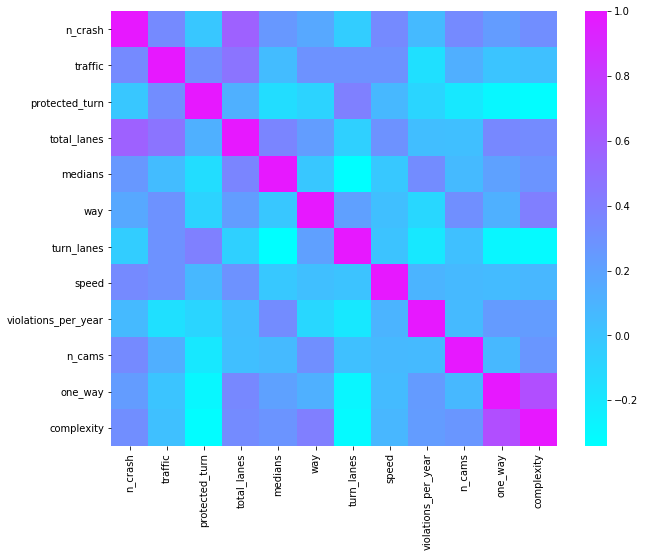

In [137]:
import seaborn as sns

plt.figure(figsize = (10,8))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

In [132]:
crash_df.describe()

,injuries_per_year,crash_per_year,danger_metric,traffic_per_lane,traffic,protected_ratio,complexity,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,daily_traffic,speed,n_cams,violations_per_year,n_crash,injuries_total,injuries_fatal,injuries_non_incapacitating,lanes_per_direction
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.0,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,2.003300,5.730881,8.188738,8086.435897,51308.333333,0.352564,0.750000,2.198718,6.608974,0.429487,0.115385,0.051282,4.102564,0.134615,0.237179,0.134615,0.160256,0.205128,3.294872,41.881588,-87.698146,1.0,51308.333333,35.705128,2.019231,5386.977776,40.673077,15.955128,0.089744,9.230769,1.617842
std,32.823366,68.793987,103.987951,2219.462240,14494.790870,0.479307,1.205498,1.612131,1.899316,0.779679,0.320514,0.221283,0.456911,0.441209,0.623333,0.342412,0.368025,0.564749,1.281219,0.084232,0.051210,0.0,14494.790870,3.521763,0.211634,9083.656691,25.929722,12.820016,0.399545,7.563790,0.454804
min,-295.106383,-566.914894,-881.436170,3011.000000,21600.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.677774,-87.812226,1.0,21600.000000,30.000000,1.000000,-24380.430108,2.000000,0.000000,0.000000,0.000000,1.000000
25%,2.099425,7.198028,10.497124,6607.750000,42175.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,41.808363,-87.735326,1.0,42175.000000,35.000000,2.000000,2580.118118,26.000000,8.000000,0.000000,5.000000,1.500000
50%,3.599014,10.197206,15.595727,8077.500000,49400.000000,0.000000,0.000000,2.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,41.903494,-87.698817,1.0,49400.000000,35.000000,2.000000,3933.722268,35.000000,13.000000,0.000000,7.000000,1.500000
75%,5.698439,14.995892,21.294166,9653.000000,58300.000000,1.000000,1.000000,4.000000,8.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,41.945941,-87.662591,1.0,58300.000000,35.000000,2.000000,5977.512325,50.000000,20.000000,0.000000,12.000000,2.000000
max,146.000000,305.272727,471.181818,13925.000000,105500.000000,1.000000,6.000000,4.000000,14.000000,3.000000,1.000000,1.000000,6.000000,2.000000,3.000000,1.000000,1.000000,3.000000,6.000000,42.012234,-87.575373,1.0,105500.000000,65.000000,3.000000,68155.454545,226.000000,99.000000,3.000000,48.000000,3.500000


# One Hot Encoding

In [138]:
crash_df.columns

Index(['injuries_per_year', 'crash_per_year', 'danger_metric',
       'traffic_per_lane', 'traffic', 'protected_ratio', 'complexity',
       'protected_turn', 'total_lanes', 'medians', 'exit', 'split', 'way',
       'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes',
       'lat', 'long', 'rlc', 'intersection', 'daily_traffic', 'speed',
       'n_cams', 'violations_per_year', 'n_crash', 'injuries_total',
       'injuries_fatal', 'injuries_non_incapacitating', 'lanes_per_direction'],
      dtype='object')

In [139]:
# get rid of categories that have high correlation and others.

df_continuous = df_cont.copy()
#df_ohe = crash_df[categoricals] # defined earlier
df_ohe = df_final[categoricals] # defined earlier
df_ohe[categoricals] = df_ohe[categoricals].astype(str)

# One hot encoding   
#df_ohe = pd.get_dummies(df_ohe, columns=['way'], drop_first=True)
df_final = pd.concat([df_continuous, df_ohe], axis=1)

In [140]:
#df_final = df_final.drop(columns=['traffic_density_k', 'protected_turn', 'medians', 'violations', 'n_crash', 'exit', 'split', 'underpass', 'angled', 'triangle', 'rlc', 'n_cams'])

In [141]:
pd.options.display.max_columns = 100
df_final.head()

,n_crash,traffic,protected_turn,total_lanes,medians,way,turn_lanes,speed,violations_per_year,n_cams,one_way,complexity,exit,split,underpass,angled,triangle,no_left
0,45,43100,2,6,2,4,2,35,6683.368940,2,0,1,0,0,0,1,0,0
1,39,42500,4,6,2,4,4,35,68155.454545,2,0,0,0,0,0,0,0,0
2,39,41800,4,6,2,4,4,35,6200.201315,2,0,0,0,0,0,0,0,0
3,44,36500,2,10,2,4,0,35,7910.632703,2,0,0,0,1,0,0,0,2
4,73,42400,2,8,2,4,2,35,3315.891537,2,0,0,0,1,0,0,0,0


## Feature selection

In [142]:

X_ = df_final.drop(target, axis=1)  # drop my potential targets

y = df_final[target]

In [143]:
### FEATURE SELECTION

#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg)
selector = selector.fit(X_, y)
print(selector.support_)
print(X_.columns)

[False False  True False  True False False False  True  True  True  True
  True False  True False False]
Index(['traffic', 'protected_turn', 'total_lanes', 'medians', 'way',
       'turn_lanes', 'speed', 'violations_per_year', 'n_cams', 'one_way',
       'complexity', 'exit', 'split', 'underpass', 'angled', 'triangle',
       'no_left'],
      dtype='object')


In [144]:
selector.support_ 
print('Feature Selection')
selected_features = []
print('{:>20} {:^8} {:^8} {:^8}'.format('FEATURE', 'RANK', 'SELECT', 'COEFFICIENT'))


#print(selector.estimator_.coef_)
step = 0

for i in range(len(X_.columns)):
    rank = selector.ranking_[i]
    select = selector.support_[i]
    col = X_.columns[i]
   
    if select: 
        coef = selector.estimator_.coef_[step]
        step+=1
        selected_features.append([col, rank])
    else:
        coef = 0
    
    print('{:>20} {:^8} {:^10} {:^5.4f}'.format(col, rank, bool(select), coef))
        
intercept = selector.estimator_.intercept_
print('\nIntercept:', intercept)


Feature Selection
             FEATURE   RANK    SELECT  COEFFICIENT
             traffic    9         0      0.0000
      protected_turn    8         0      0.0000
         total_lanes    1         1      6.2120
             medians    7         0      0.0000
                 way    1         1      -2.0664
          turn_lanes    2         0      0.0000
               speed    6         0      0.0000
 violations_per_year    10        0      0.0000
              n_cams    1         1      32.8555
             one_way    1         1      -5.5803
          complexity    1         1      2.7906
                exit    1         1      10.8203
               split    1         1      26.3866
           underpass    3         0      0.0000
              angled    1         1      -7.0222
            triangle    5         0      0.0000
             no_left    4         0      0.0000

Intercept: -60.85176186051689


In [145]:
selected_features.sort(key=lambda x: x[1])
selected_features

[['total_lanes', 1],
 ['way', 1],
 ['n_cams', 1],
 ['one_way', 1],
 ['complexity', 1],
 ['exit', 1],
 ['split', 1],
 ['angled', 1]]

## Apply my feature selection to data

In [146]:
selector.support_


array([False, False,  True, False,  True, False, False, False,  True,
        True,  True,  True,  True, False,  True, False, False])

In [147]:
#X_ = X.iloc[:,selector.support_] 
keep = ['total_lanes', 'way', 'violations_per_year', 'violations_per_year', 
        'n_cams', 'one_way', 'exit', 'split']

In [148]:
print(X_.columns)
print(selector.support_)
X = df_final[keep]
# this did not result in a positive r2 value.  I will manually select some of my features instead

Index(['traffic', 'protected_turn', 'total_lanes', 'medians', 'way',
       'turn_lanes', 'speed', 'violations_per_year', 'n_cams', 'one_way',
       'complexity', 'exit', 'split', 'underpass', 'angled', 'triangle',
       'no_left'],
      dtype='object')
[False False  True False  True False False False  True  True  True  True
  True False  True False False]


# Linear Regression

In [151]:
# Import statsmodels.api as sm
from statsmodels.formula.api import ols

In [152]:
pred_sum = '+'.join(X.columns)
formula = target + '~' + pred_sum

In [153]:
model = ols(formula=formula, data=pd.concat([X, y], axis=1)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_crash   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     9.592
Date:                Sat, 20 Feb 2021   Prob (F-statistic):           4.20e-17
Time:                        00:20:40   Log-Likelihood:                -662.38
No. Observations:                 156   AIC:                             1365.
Df Residuals:                     136   BIC:                             1426.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -64.7706     26.254     -2.467      0.015    -116.690     -12.851
exit[T.1]               9.1240      5.998      1.521      0.131      -2.738      20.986
split[T.1]             36.1284      8.792      4.109      0.000      18.742      53.515
underpass[T.1]          5.0083      7.004      0.715      0.476      -8.843      18.860
underpass[T.2]         -0.2389      6.631     -0.036      0.971     -13.353      12.875
angled[T.1]            -6.3440      5.238     -1.211      0.228     -16.702       4.014
triangle[T.1]           3.6927      5.631      0.656      0.513      -7.443      14.829
no_left[T.1]          -17.2859      6.935     -2.493      0.014     -30.999      -3.572
no_left[T.2]            2.7863      6.818      0.409      0.683     -10.697      16.270
no_left[T.3]          -18.6304     16.310     -1.142      0.255     -50.885      13.624
traffic                 0.0002      0.000      1.329      0.186   -8.77e-05       0.000
protected_turn          0.0949      1.139      0.083      0.934      -2.158       2.348
total_lanes             4.1372      1.226      3.376      0.001       1.713       6.561
medians                -0.7294      2.415     -0.302      0.763      -5.506       4.047
way                    -7.7918      4.528     -1.721      0.088     -16.747       1.163
turn_lanes              1.0400      1.765      0.589      0.557      -2.451       4.531
speed                   0.8991      0.461      1.951      0.053      -0.012       1.811
violations_per_year -1.717e-05      0.000     -0.090      0.928      -0.000       0.000
n_cams                 30.1454      8.018      3.760      0.000      14.290      46.001
one_way                -5.4916      4.081     -1.346      0.181     -13.561       2.578
complexity              5.5117      2.376      2.320      0.022       0.813      10.210
==============================================================================
Omnibus:                       44.814   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.118
Skew:                           1.075   Prob(JB):                     5.07e-32
Kurtosis:                       7.189   Cond. No.                     6.89e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.41e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The bad:
Large JB is troubling.  Errors are not normally distributed.
This is the lowest I could get the BIC and AIC.


The good
F-statistic looks okay with low pval.
Low skew value is good to see.

### Test Train Split

In [165]:
def cross_val(model, X, y):
    # return a cross val score for my models
    pred = cross_val_score(model, X, y, cv=5)
    return pred.mean()

def print_evaluate(true, predicted):  
    # print out all of my stats for the model
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    # get multiple stats on my model predictions
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [192]:
X = df_final.drop(['n_crash'], axis=1)
y = df_final['n_crash']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [193]:
reg = LinearRegression()
reg.fit(X, y)  # my regression object

pred = reg.predict(X_test)

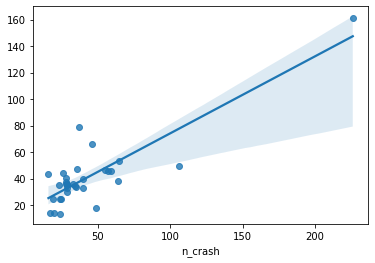

In [194]:
sns.regplot(y_test, pred)
# plt.xlim(0,80)
# plt.ylim(0,60)

### Plot residuals

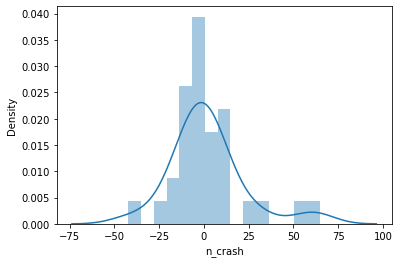

In [195]:
sns.distplot((y_test - pred), bins=15);

In [196]:
test_pred = reg.predict(X_test)
train_pred = reg.predict(X_train)

print("Linear Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y_test, test_pred)

print()
print('Train set:')
print_evaluate(y_train, train_pred)

Linear Regression Results:
Test set:
MAE: 13.75543589633439
MSE: 429.01364459685914
RMSE: 20.712644558261005
R2 Square 0.6954380018834969

Train set:
MAE: 11.918888727718175
MSE: 271.9916270651537
RMSE: 16.492168658643827
R2 Square 0.42758378722151225


I need more information about the intersection other than just names.
I need descriptive info, but it isn't available in violations table.  Crash data does have some stuff though

In [197]:
# would like to use ridge because I seem to have some correlated data

from sklearn.linear_model import Ridge, RidgeCV
import numpy as np

clf = Ridge(alpha=1, fit_intercept=False)
clf.fit(X, y)
print(clf.score(X,y))

clf2 = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X, y)
clf2.score(X,y)


0.5084719764389013


0.5420839210150153

In [198]:
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))


     traffic: 0.00014187422938034878
protected_turn: -0.06617411126476552
 total_lanes: 4.600974241567427
     medians: -0.26030049048201026
         way: -4.888328380845565
  turn_lanes: 1.8558013186597888
       speed: 1.0340496643611752
violations_per_year: -5.476554185841445e-05
      n_cams: 29.51608576277227
     one_way: -3.862224197689006
  complexity: 3.7804909853436155
        exit: 10.386370089163588
       split: 33.955090082315714
   underpass: 2.0885906022547633
      angled: -6.816038004884324
    triangle: 1.98379249649864
     no_left: -2.2961082457133


In [199]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(reg, X_train, y_train)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,13.755436,429.013645,20.712645,0.695438,0.115915


## Ridge Model

In [200]:
from sklearn.linear_model import Ridge, RidgeCV

model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100])
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print("Ridge Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y_test, test_pred)

print()
print('Train set:')
print_evaluate(y_train, train_pred)

Ridge Regression Results:
Test set:
MAE: 18.903605170864033
MSE: 916.6770129481197
RMSE: 30.276674403707545
R2 Square 0.3492398523751036

Train set:
MAE: 11.04764598502393
MSE: 232.8760898858197
RMSE: 15.260278171967236
R2 Square 0.5099038494035257


In [201]:
ridge = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(model, X_train, y_train)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df.append(ridge)

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,13.755436,429.013645,20.712645,0.695438,0.115915
0,Ridge Regression,18.903605,916.677013,30.276674,0.349240,0.097365


### Results of intersection characteristic analysis
The characteristics only accounted for about 23% of the crashes using cross validation.  I got a much higher r2 value with OLS, but accept the cross validated result.

Adding in more characteristics improves performance, but the individual p_vals do not support their inclusion.

Overall, the biggest factor in determining how many crashes occur is traffic volume as measured by:
- lanes
- ways
- violations
- traffic (average daily)

Few of the gathered characteristics meaningfully informed the model.  (disappointing since they took hours to gather).
One possible hypothesis: dangerous intersections have had characteristics changed to mitigate the accidents.  Medians, no turns, protected turns etc. were installed to make the intersection safer.  Perhaps they only occur at the more dangerous intersections, and their presence is the result rather than the cause of the accidents.